In [51]:
import math
import yaml
import librosa
import torch
import torch.nn as nn
from os import path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from effortless_config import Config
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from core import get_scheduler, multiscale_fft, safe_log, mean_std_loudness

In [52]:
from models import DDSP_signal_only, DDSP_with_features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

Using device: cuda:0


In [53]:
def conv1d_layer(in_size, output_size, kernel_size, n_layers, padding_same=False, activation='relu'):
    dimensions = [in_size] + (n_layers) * [output_size]
    net = []
    for i in range(n_layers):
        
        if padding_same:
            net.append(torch.nn.Conv1d(dimensions[i], dimensions[i + 1], kernel_size, padding='same'))
        else:
            net.append(torch.nn.Conv1d(dimensions[i], dimensions[i + 1], kernel_size))

        net.append(torch.nn.BatchNorm1d(dimensions[i + 1]))
        
        if activation=='tanh':
            net.append(torch.nn.Tanh())
        else:
            net.append(torch.nn.ReLU())
    return torch.nn.Sequential(*net)

class Test(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1d = conv1d_layer(1, 512, 5, 3)
        self.lstm = torch.nn.LSTM(1044, 1024, num_layers=3, batch_first=True)
        self.dense = torch.nn.Linear(1024, 80)
        self.conv1d_2 = conv1d_layer(80, 512, 5, 4, padding_same=True, activation='relu')
        self.residual_conv = torch.nn.Conv1d(512, 80, 5, padding='same')
        self.batch_norm = torch.nn.BatchNorm1d(80)

    def forward(self, pitch, loudness, embedding):

        cat_vector = torch.cat([
            pitch,
            loudness,
            embedding,
        ], -1).unsqueeze(1)

        x = self.conv1d(cat_vector)
        x = self.lstm(x)[0]
        x = self.dense(x)
        x_res = self.conv1d_2(torch.permute(x, (0, 2, 1)))
        x_res = self.residual_conv(x_res)
        x_res = self.batch_norm(x_res)
        x_res = torch.permute(x_res, (0, 2, 1))
        x = x + x_res

        return x

ddsp_model = Test().to(device)

In [54]:
from datasets.dataset_w_embedding import Dataset, get_files
from effortless_config import Config
import yaml
import torch

#get_files("config.yaml")

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)
batch_size = config["hyperparams"]["batch_size"]
dataloader_train = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader_train))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader_train))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader_train))['loudness'].size(), "\nSize of sig batch:", next(iter(dataloader_train))['embeddings'].size())

Size of dataset: 217 
Size of sig batch: torch.Size([16, 64000]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 256])


In [55]:
class args(Config):
    CONFIG = "config.yaml"
    NAME = "debug3/male_speech"
    ROOT = "runs"
    STEPS = 500000
    START_LR = 1e-3
    STOP_LR = 1e-4
    DECAY_OVER = 400000

mean_loudness, std_loudness = mean_std_loudness(dataloader_train)
config["data"]["mean_loudness"] = mean_loudness
config["data"]["std_loudness"] = std_loudness

writer = SummaryWriter(path.join(args.ROOT, args.NAME), flush_secs=20)

with open(path.join(args.ROOT, args.NAME, "config.yaml"), "w") as out_config:
    yaml.safe_dump(config, out_config)

opt = torch.optim.Adam(ddsp_model.parameters(), lr=args.START_LR)

schedule = get_scheduler(
    len(dataloader_train),
    args.START_LR,
    args.STOP_LR,
    args.DECAY_OVER,
)

best_loss = float("inf")
mean_loss = 0
n_element = 0
step = 0
epochs = int(np.ceil(args.STEPS / len(dataloader_train)))

In [56]:
import soundfile as sf
import torchaudio.transforms as T

losses = []

mel_spec = T.MelSpectrogram(sample_rate=16000, n_mels=80, n_fft=1024, hop_length=125).to(device)
criterion = torch.nn.MSELoss().to(device)

for e in tqdm(range(epochs)):
    total_loss = 0
    for batch in dataloader_train:
        s = batch['signals'].to(device)
        p = batch['pitches'].to(device)
        l = batch['loudness'].to(device)
        em = batch['embeddings'].to(device)

        l = (l - mean_loudness) / std_loudness

        y = ddsp_model(p, l, em).squeeze(-1)
        X1 = torch.permute(mel_spec(s)[:, :, :-1], (0, 2, 1))

        loss = 0
        loss = criterion(X1, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        writer.add_scalar("loss", loss.item(), step)

        step += 1

        n_element += 1
        mean_loss += (loss.item() - mean_loss) / n_element
        total_loss += loss.item()

    if not e % 10:
        if mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(
                ddsp_model.state_dict(),
                path.join(args.ROOT, args.NAME, "state.pth"),
            )

        mean_loss = 0
        n_element = 0
    
    total_loss /= len(dataloader_train)
    losses.append(total_loss)

  6%|▌         | 2156/38462 [1:59:50<33:38:07,  3.34s/it] 


KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

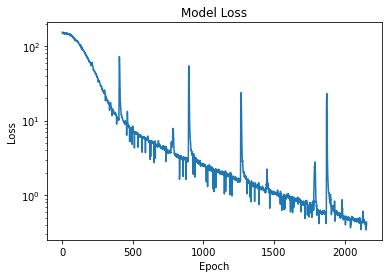

In [57]:
import matplotlib.pyplot as plt

plt.semilogy(losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

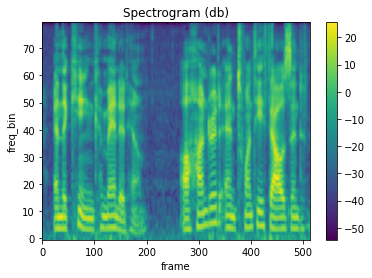

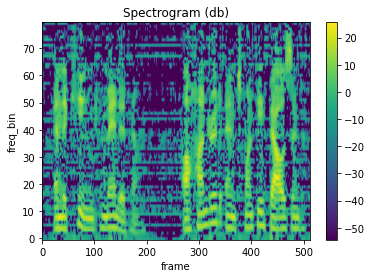

In [64]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T

mel_spec = T.MelSpectrogram(sample_rate=16000, n_mels=80, n_fft=1024, hop_length=125).to('cpu')


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

batch = next(iter(dataloader_train))
my_s = batch['signals'][0]
my_p = batch['pitches']
my_l = batch['loudness']
my_e = batch['embeddings']
my_mel_spec = mel_spec(my_s)

model = Test()
model.load_state_dict(torch.load("runs/debug3/male_speech/state.pth"))

y = model(my_p, my_l, my_e).squeeze(-1)

plot_spectrogram(my_mel_spec)
plot_spectrogram(torch.permute(y, (0, 2, 1))[0].detach().cpu().numpy())